# Customer Segmentation Anaylsis

This is the description code for customer segmentation analysis. The original resource is from the course [Customer Segmentation Analysis in Python](https://www.datacamp.com/courses/customer-segmentation-in-python) instructed by Karolis Urbonas on [DataCamp](https://www.datacamp.com). The dataset is from UCI ML repo, which is also available from [Kaggle](https://www.kaggle.com/jihyeseo/online-retail-data-set-from-uci-ml-repo).

In [1]:
# import library
import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

## 1. Import data

In [84]:
# Import the dataset
online = pd.read_excel('Online Retail.xlsx')

In [85]:
# drop the row missing customerID
online = online[online.CustomerID.notnull()]

I'll use only the subset of the full dataset, taking 20% of samples.

In [86]:
# use a subset of full data
np.random.seed(306)
online = online.sample(frac = .3).reset_index(drop = True)
online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,542401,22502,PICNIC BASKET WICKER SMALL,2,2011-01-27 15:51:00,5.95,14541.0,United Kingdom
1,542231,22726,ALARM CLOCK BAKELIKE GREEN,2,2011-01-26 13:40:00,3.75,16714.0,United Kingdom
2,556956,22090,PAPER BUNTING RETROSPOT,40,2011-06-16 09:04:00,2.55,13694.0,United Kingdom
3,573874,23581,JUMBO BAG PAISLEY PARK,10,2011-11-01 12:45:00,2.08,13868.0,United Kingdom
4,580742,23343,JUMBO BAG VINTAGE CHRISTMAS,200,2011-12-06 09:30:00,1.75,13694.0,United Kingdom


In [87]:
# extract year, month and day 
online['InvoiceDay'] = online.InvoiceDate.apply(lambda x: dt.datetime(x.year, x.month, x.day))
online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDay
0,542401,22502,PICNIC BASKET WICKER SMALL,2,2011-01-27 15:51:00,5.95,14541.0,United Kingdom,2011-01-27
1,542231,22726,ALARM CLOCK BAKELIKE GREEN,2,2011-01-26 13:40:00,3.75,16714.0,United Kingdom,2011-01-26
2,556956,22090,PAPER BUNTING RETROSPOT,40,2011-06-16 09:04:00,2.55,13694.0,United Kingdom,2011-06-16
3,573874,23581,JUMBO BAG PAISLEY PARK,10,2011-11-01 12:45:00,2.08,13868.0,United Kingdom,2011-11-01
4,580742,23343,JUMBO BAG VINTAGE CHRISTMAS,200,2011-12-06 09:30:00,1.75,13694.0,United Kingdom,2011-12-06


In [88]:
# the number of customers
online.CustomerID.nunique()

4222

## 2. RFM values

RFM (Recency, Frequency, Monetary) is a very Simple Technique that we can apply it very easy and get the super useful analysis for our Customer Segmentation. Recency is days since the customers made the last purchase and by definition, the lower it is the better. Frequency is the number of transaction in the last 12 months. Monetary value is the total amout of money the customers spent in the last 12 months.

In [89]:
online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDay
0,542401,22502,PICNIC BASKET WICKER SMALL,2,2011-01-27 15:51:00,5.95,14541.0,United Kingdom,2011-01-27
1,542231,22726,ALARM CLOCK BAKELIKE GREEN,2,2011-01-26 13:40:00,3.75,16714.0,United Kingdom,2011-01-26
2,556956,22090,PAPER BUNTING RETROSPOT,40,2011-06-16 09:04:00,2.55,13694.0,United Kingdom,2011-06-16
3,573874,23581,JUMBO BAG PAISLEY PARK,10,2011-11-01 12:45:00,2.08,13868.0,United Kingdom,2011-11-01
4,580742,23343,JUMBO BAG VINTAGE CHRISTMAS,200,2011-12-06 09:30:00,1.75,13694.0,United Kingdom,2011-12-06


The last day of purchase in total is 09 DEC, 2011. To calculate the day periods, let's set one day after the last one, or 10 DEC as a pin date. We will cound the diff days with pin_date.

In [90]:
print('Min : {}, Max : {}'.format(min(online.InvoiceDay), max(online.InvoiceDay)))

Min : 2010-12-01 00:00:00, Max : 2011-12-09 00:00:00


In [91]:
pin_date = max(online.InvoiceDay) + dt.timedelta(1)

In [92]:
# Create total spend dataframe
online['TotalSum'] = online.Quantity * online.UnitPrice

online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDay,TotalSum
0,542401,22502,PICNIC BASKET WICKER SMALL,2,2011-01-27 15:51:00,5.95,14541.0,United Kingdom,2011-01-27,11.9
1,542231,22726,ALARM CLOCK BAKELIKE GREEN,2,2011-01-26 13:40:00,3.75,16714.0,United Kingdom,2011-01-26,7.5
2,556956,22090,PAPER BUNTING RETROSPOT,40,2011-06-16 09:04:00,2.55,13694.0,United Kingdom,2011-06-16,102.0
3,573874,23581,JUMBO BAG PAISLEY PARK,10,2011-11-01 12:45:00,2.08,13868.0,United Kingdom,2011-11-01,20.8
4,580742,23343,JUMBO BAG VINTAGE CHRISTMAS,200,2011-12-06 09:30:00,1.75,13694.0,United Kingdom,2011-12-06,350.0


In [93]:
# calculate RFM values
rfm = online.groupby('CustomerID').agg({
    'InvoiceDate' : lambda x: (pin_date - x.max()).days,
    'InvoiceNo' : 'count', 
    'TotalSum' : 'sum'})

In [94]:
# renmae the columns
rfm.rename(columns = {'InvoiceDate' : 'Recency', 
                      'InvoiceNo' : 'Frequency', 
                      'TotalSum' : 'Monetary'}, inplace = True)

rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12347.0,2,45,980.10
12348.0,248,9,728.88
12349.0,18,25,486.87
12350.0,310,3,45.70
12352.0,36,32,1353.48


As the three columns are grouped by customers and count the days from the max date value, `Recency` is the days since the last purchase of a customer. `Frequency` is the number of purchases of a customer and `Monetary` is the total amount of spend of a customer.  

## 3. RFM quartiles 

Let's group the customers based on `Recency` and `Frequency`. We will use quantile values to get three equal percentile groups an then make three separate gruops. As the lower `Recency` value is the better, we will label them in decreasing order.      

In [95]:
# create labels and assign them to tree percntile groups 
r_labels = range(4, 0, -1)
r_groups = pd.qcut(rfm.Recency, q = 4, labels = r_labels)

f_labels = range(1, 5)
f_groups = pd.qcut(rfm.Frequency, q = 4, labels = f_labels)

m_labels = range(1, 5)
m_groups = pd.qcut(rfm.Monetary, q = 4, labels = m_labels)

m_groups.head()

CustomerID
12347.0    4
12348.0    4
12349.0    3
12350.0    1
12352.0    4
Name: Monetary, dtype: category
Categories (4, int64): [1 < 2 < 3 < 4]

In [96]:
# make a new column for group labels
rfm['R'] = r_groups.values
rfm['F'] = f_groups.values
rfm['M'] = m_groups.values

In [97]:
# sum up the three columns
rfm['RFM_Segment'] = rfm.apply(lambda x: str(x['R']) + str(x['F']) + str(x['M']), axis = 1)
rfm['RFM_Score'] = rfm[['R', 'F', 'M']].sum(axis = 1)
rfm.head() 

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12347.0,2,45,980.10,4,4,4,444,12.0
12348.0,248,9,728.88,1,2,4,124,7.0
12349.0,18,25,486.87,3,3,3,333,9.0
12350.0,310,3,45.70,1,1,1,111,3.0
12352.0,36,32,1353.48,3,3,4,334,10.0


With this value, we can go further analysis such as what is the average values for each RFM values or leveling
customers in total RFM score.

In [98]:
# calculate averae values for each RFM_score
rfm_agg = rfm.groupby('RFM_Score').agg({
    'Recency' : 'mean',
    'Frequency' : 'mean',
    'Monetary' : ['mean', 'count']
})

rfm_agg.round(1).head()

Recency Frequency Monetary      
             mean      mean     mean count
RFM_Score                                 
3.0         258.3       2.9    -57.5   409
4.0         172.1       4.5     60.0   372
5.0         143.5       6.5    106.5   495
6.0         104.0       9.3    191.8   471
7.0          81.3      13.0    237.5   418

The final score will be the aggregated value of RFM and we can make groups based on the `RFM_Score`

In [99]:
# assign labels from total score
score_labels = ['Green', 'Broze', 'Silver', 'Gold']
score_groups = pd.qcut(rfm.RFM_Score, q = 4, labels = score_labels)
rfm['RFM_Level'] = score_groups.values

rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_Level
CustomerID,,,,,,,,,
12347.0,2,45,980.10,4,4,4,444,12.0,Gold
12348.0,248,9,728.88,1,2,4,124,7.0,Broze
12349.0,18,25,486.87,3,3,3,333,9.0,Silver
12350.0,310,3,45.70,1,1,1,111,3.0,Green
12352.0,36,32,1353.48,3,3,4,334,10.0,Silver


## 4. Customer Segmentation with Kmeans

We can also apply Kmeans clustering with RFM values. As Kmeans clustering require data to be normalized and has a symmetric distribution, preprocessing process in scale is needed. 

### 4-1. Preprocessing 

C:\Users\jjone\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


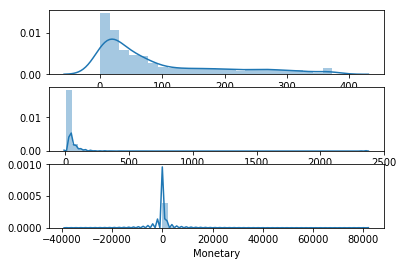

In [100]:
# plot the distribution of RFM values
plt.subplot(3, 1, 1); sns.distplot(rfm.Recency)
plt.subplot(3, 1, 2); sns.distplot(rfm.Frequency)
plt.subplot(3, 1, 3); sns.distplot(rfm.Monetary)

plt.show()

As you can see above, the values are skewed and need to be normalized. Due to the zero or negative values in `Recency` and `MonetaryValue`, we need to set them 1 before log transformation and scaling.

In [102]:
# define function for the values below 0
def neg_to_zero(x):
    if x <= 0:
        return 1
    else:
        return x

In [103]:
# apply the function to Recency and MonetaryValue column 
rfm['Recency'] = [neg_to_zero(x) for x in rfm.Recency]
rfm['Monetary'] = [neg_to_zero(x) for x in rfm.Monetary]
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_Level
CustomerID,,,,,,,,,
12347.0,2,45,980.10,4,4,4,444,12.0,Gold
12348.0,248,9,728.88,1,2,4,124,7.0,Broze
12349.0,18,25,486.87,3,3,3,333,9.0,Silver
12350.0,310,3,45.70,1,1,1,111,3.0,Green
12352.0,36,32,1353.48,3,3,4,334,10.0,Silver


In [104]:
# unskew the data
rfm_log = rfm[['Recency', 'Frequency', 'Monetary']].apply(np.log, axis = 1).round(3)
rfm_log.head()

,Recency,Frequency,Monetary
CustomerID,,,
12347.0,0.693,3.807,6.888
12348.0,5.513,2.197,6.592
12349.0,2.890,3.219,6.188
12350.0,5.737,1.099,3.822
12352.0,3.584,3.466,7.210


In [105]:
rfm_log.describe()

,Recency,Frequency,Monetary
count,4222.000000,4222.000000,4222.000000
mean,3.738968,2.566761,5.303256
std,1.486877,1.258514,1.428801
min,0.000000,0.000000,0.000000
25%,2.833000,1.792000,4.454500
50%,3.922000,2.565000,5.328500
75%,4.990000,3.466000,6.209750
max,5.922000,7.769000,11.313000


In [106]:
# scale the data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)

In [107]:
# transform into a dataframe
rfm_scaled = pd.DataFrame(rfm_scaled, index = datamart.index, columns = rfm_log.columns)
rfm_scaled.head()

,Recency,Frequency,Monetary
CustomerID,,,
12347.0,-2.048810,0.985595,1.109274
12348.0,1.193267,-0.293843,0.902083
12349.0,-0.571042,0.518322,0.619295
12350.0,1.343937,-1.166403,-1.036835
12352.0,-0.104236,0.714609,1.334664


C:\Users\jjone\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


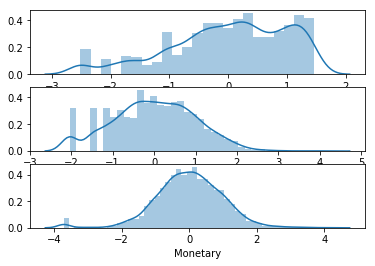

In [108]:
# plot the distribution of RFM values
plt.subplot(3, 1, 1); sns.distplot(rfm_scaled.Recency)
plt.subplot(3, 1, 2); sns.distplot(rfm_scaled.Frequency)
plt.subplot(3, 1, 3); sns.distplot(rfm_scaled.Monetary)

plt.show()

### 3-2. K-means clustering

With the Elbow method, we can get the optimal number of clusters.  

In [109]:
# initiate an empty dictionary
wcss = {}

# Elbow method with for loop
for i in range(1, 21):
    kmeans = KMeans(n_clusters= i, init= 'k-means++', max_iter= 300)
    kmeans.fit(rfm_scaled)
    wcss[i] = kmeans.inertia_

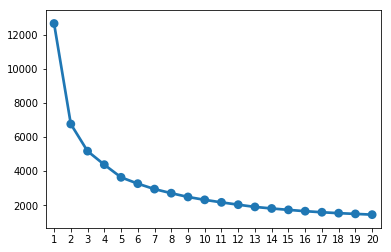

In [110]:
sns.pointplot(x = list(wcss.keys()), y = list(wcss.values()))
plt.show()

In [111]:
# choose n_clusters = 4
clus = KMeans(n_clusters= 4, init= 'k-means++', max_iter= 300)
clus.fit(rfm_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [112]:
# Assign the clusters to datamart
datamart['Cluster'] = clus.labels_
datamart.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,Cluster
CustomerID,,,,,,,,,
12347.0,2,45,980.10,4,4,4,444,12.0,0
12348.0,248,9,728.88,1,2,4,124,7.0,1
12349.0,18,25,486.87,3,3,3,333,9.0,3
12350.0,310,3,45.70,1,1,1,111,3.0,2
12352.0,36,32,1353.48,3,3,4,334,10.0,0


### 3-3. Visualization

Now we can go further analysis with this label as we did with RFM quantils.

In [114]:
datamart.groupby('Cluster').agg({
    'Recency' : 'mean',
    'Frequency' : 'mean',
    'Monetary' : ['mean', 'count']
}).round(3)

Recency Frequency  Monetary      
            mean      mean      mean count
Cluster                                   
0         17.372    82.752  1824.132   992
1        138.890    16.527   314.041  1421
2        174.553     3.219     6.623   929
3         18.652    15.323   210.346   880

In marketing, snail plot and heatmap are often used plot for visualization. I'll use the `rfm_scaled` dataframe with normalized rfm values for the plot.

In [115]:
# assign cluster column 
rfm_scaled['Cluster'] = clus.labels_
rfm_scaled.reset_index(inplace = True)

In [116]:
rfm_scaled.head()

,CustomerID,Recency,Frequency,Monetary,Cluster
0,12347.0,-2.048810,0.985595,1.109274,0
1,12348.0,1.193267,-0.293843,0.902083,1
2,12349.0,-0.571042,0.518322,0.619295,3
3,12350.0,1.343937,-1.166403,-1.036835,2
4,12352.0,-0.104236,0.714609,1.334664,0


In [117]:
# melt the dataframe
rfm_melted = pd.melt(frame= rfm_scaled, id_vars= ['CustomerID', 'Cluster'], var_name = 'Metrics', value_name = 'Value')
rfm_melted.head()

,CustomerID,Cluster,Metrics,Value
0,12347.0,0,Recency,-2.048810
1,12348.0,1,Recency,1.193267
2,12349.0,3,Recency,-0.571042
3,12350.0,2,Recency,1.343937
4,12352.0,0,Recency,-0.104236


C:\Users\jjone\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


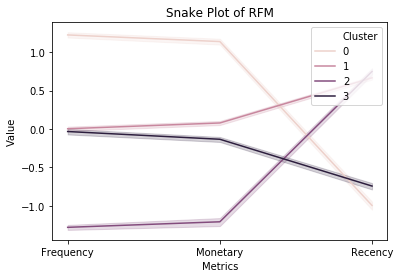

In [118]:
# a snake plot
sns.lineplot(x = 'Metrics', y = 'Value', hue = 'Cluster', data = rfm_melted)
plt.title('Snake Plot of RFM')
plt.legend(loc = 'upper right')

Heatmap is efficient for comparing the standardized values. 

In [119]:
# the mean value for each cluster
cluster_avg = datamart.groupby('Cluster').mean().iloc[:, 0:3]
cluster_avg.head()

,Recency,Frequency,Monetary
Cluster,,,
0,17.371976,82.752016,1824.131845
1,138.890218,16.527094,314.041288
2,174.553283,3.218515,6.622949
3,18.652273,15.322727,210.346000


In [120]:
# the mean value in total 
total_avg = datamart.iloc[:, 0:3].mean()
total_avg

Recency       93.124112
Frequency     28.907864
Monetary     579.594661
dtype: float64

In [121]:
# the proportional mean value
prop_rfm = cluster_avg/total_avg - 1
prop_rfm

,Recency,Frequency,Monetary
Cluster,,,
0,-0.813454,1.862613,2.147254
1,0.491453,-0.428284,-0.458171
2,0.874416,-0.888663,-0.988573
3,-0.799705,-0.469946,-0.637081


[]

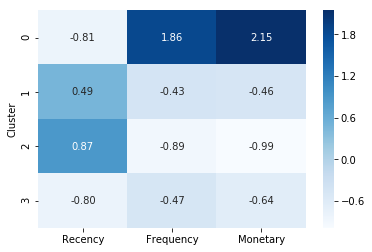

In [122]:
# heatmap
sns.heatmap(prop_rfm, cmap= 'Blues', fmt= '.2f', annot = True)
plt.plot()